# **Train**
This notebook is desired to train the Tumor Detector 2.0 with high-level training informations.

---

### **Imports**

In [1]:
# metrics
from TumorDetector2.utils.metrics import loss_menager,\
                                         apply_threshold,\
                                         DiceCoeficient
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

# data handler
from TumorDetector2.utils.weights import TrainLogging,\
                                         load_architecture
from TumorDetector2.utils.data import load_tfrecord

import numpy as np

# graphs
from TumorDetector2.utils.graphs import TrainingGraph

# system
from tensorflow._api.v2.config import list_physical_devices,\
                                      list_logical_devices,\
                                      set_visible_devices,\
                                      set_logical_device_configuration,\
                                      LogicalDeviceConfiguration
from tensorflow import GradientTape
from tqdm import tqdm

##### **Checking GPU**

In [ ]:
# checking if GPU is available
gpus = list_physical_devices(device_type='GPU')
if gpus.__len__():
    set_visible_devices(devices=gpus[0], device_type='GPU')
    # limiting GPU memory
    set_logical_device_configuration(
        device=gpus[0],
        logical_devices=[
            LogicalDeviceConfiguration(memory_limit=3584) # limiting to 3.5GB
        ]
    )
    device = list_logical_devices(device_type='GPU')
    print('GPU has been detected: ' + str(device))
else:
    print('No GPU has been detected. The GPU acceleration is not enabled, it is EXTREMELLY recommended to use GPU for training.')

### **PARAMETERS**

In [2]:
# - data
SHUFFLE_DATA = True
PREFETCH = 2
BATCH = 4

# - training
MODEL_VERSION = 'v1'
EPOCHS = 50
LEARNING_RATE = 1e-4
EARLY_STOP = 5
LOSS_TRANSFORMER = 'real'
THRESHOLD = 0.5

# - metrics
LOSS = BinaryCrossentropy()
METRIC = DiceCoeficient()
OPTIMIZER = Adam(learning_rate=LEARNING_RATE)

# - graphs
GRAPH = TrainingGraph(LOSS, METRIC, EPOCHS, BATCH)

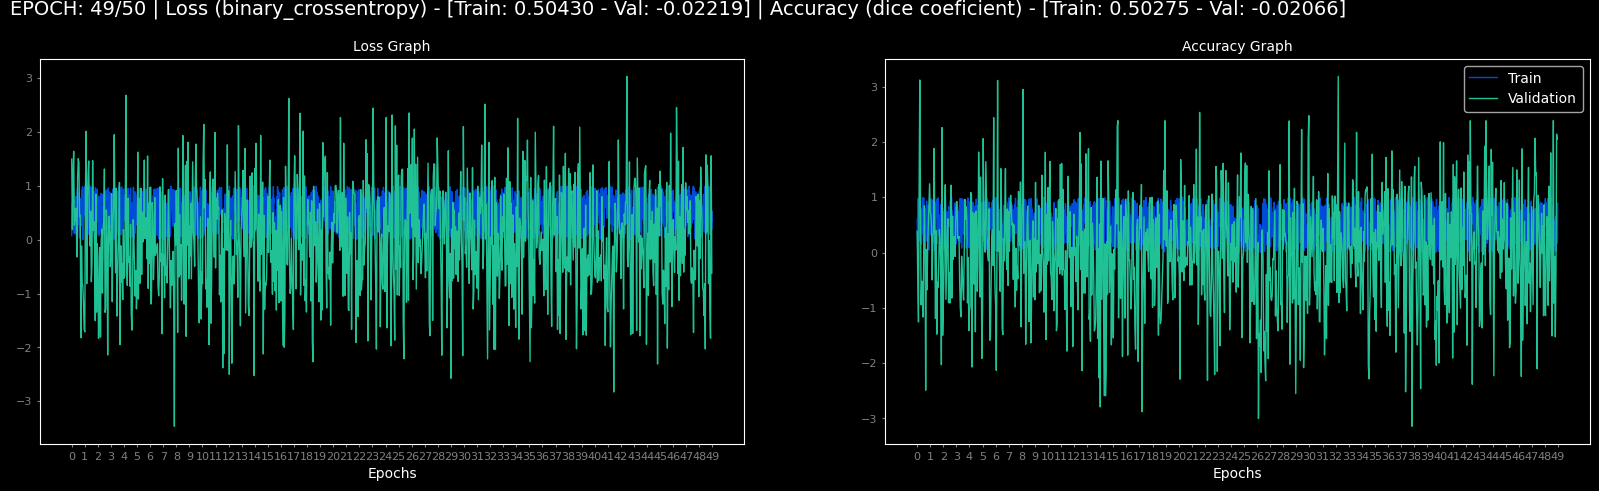

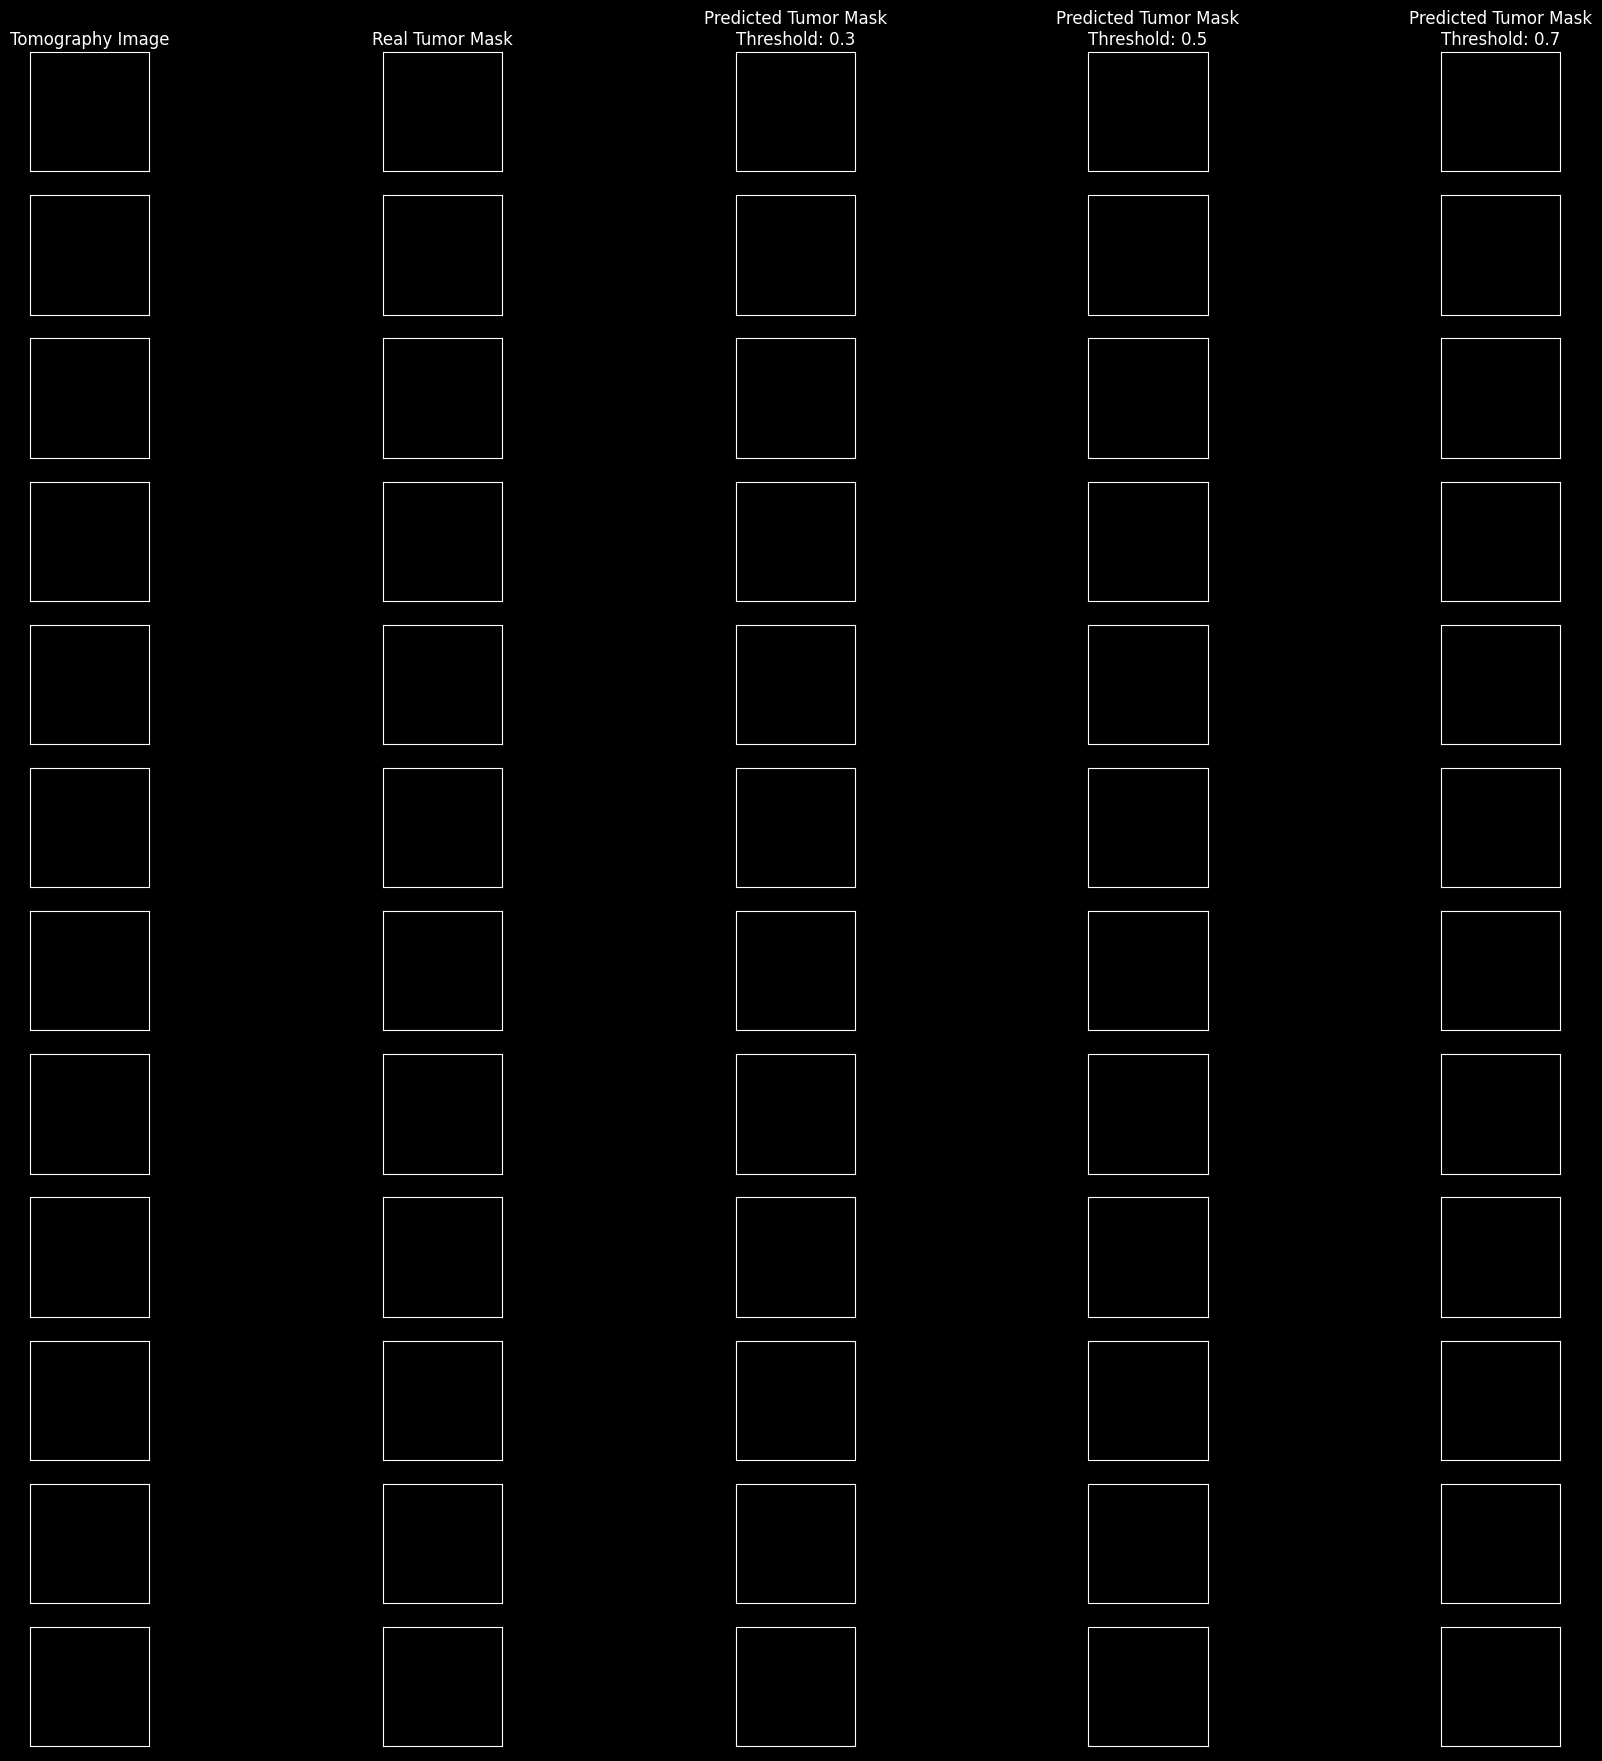

In [3]:
GRAPH.display()

### **Load Model Configs**

In [ ]:
MODEL = load_architecture(MODEL_VERSION)

### **Load TFRecord File**

In [ ]:
TRAIN_DATASET, TEST_DATASET, VAL_DATASET = load_tfrecord(BATCH, PREFETCH, SHUFFLE_DATA)

### **Training**

In [ ]:
# variables
LOSSES = []
VAL_LOSSES = []

ACCURACIES = []
VAL_ACCURACIES = []

BEST_LOSS = None
BEST_VAL_LOSS = None

ACCURACY = None
VAL_ACCURACY = None

PREVIOUS_VAL_LOSS = None

OVERFITTING = 0

TOTAL_ITERATIONS = None

TRAIN_LOGGING = TrainLogging()

for epoch in range(1, EPOCHS+1):
    
    # training inference
    ITER_TRAINING = tqdm(iterable=TRAIN_DATASET, desc=f'EPOCH: {epoch}/{EPOCHS} | Training', total=TOTAL_ITERATIONS)
    
    mean_loss = 0
    mean_accuracy = 0
    for iterations, (image, mask, label) in enumerate(ITER_TRAINING):
        
        with GradientTape() as tape:
        
            # running inference
            predicted = MODEL(image, training=True)
            
            # calculating loss
            loss = loss_menager(
                loss=LOSS(mask, predicted),
                apply=LOSS_TRANSFORMER
            )
            
            # applying threshold
            if THRESHOLD != 0.0 and type(THRESHOLD) == float:
                predicted = apply_threshold(predicted, THRESHOLD)
            
            # calculating accuracy
            accuracy = METRIC(mask, predicted)
            
            # saving results
            LOSSES.append(loss)
            ACCURACIES.append(accuracy)
            mean_loss += loss
            mean_accuracy += accuracy
            
            # gradiant
            grads = tape.gradient(target=loss, sources=MODEL.trainable_weights)
            OPTIMIZER.apply_gradients(grads_and_vars=zip(grads, MODEL.trainable_weights))
    mean_loss /= (iterations + 1) # mean loss of training
    mean_accuracy /= (iterations + 1) # mean accuracy of training
    
    # saving total iterations
    if TOTAL_ITERATIONS is None:
        TOTAL_ITERATIONS = iterations + 1
    
    # validating
    print('Validating..')
    
    mean_val_loss = 0
    mean_val_accuracy = 0
    SAMPLES = []
    for iterations, (image, mask, label) in enumerate(VAL_DATASET):
        
        # running inference
        predicted = MODEL(image, training=False)
        
        # calculating loss
        loss = loss_menager(
                loss=LOSS(mask, predicted),
                apply=LOSS_TRANSFORMER
            )

        # calculating accuracy
        if THRESHOLD != 0.0 and type(THRESHOLD) == float:
            accuracy = METRIC(mask, apply_threshold(predicted, THRESHOLD))
        else:
            accuracy = METRIC(mask, predicted)
        
        # saving results
        VAL_LOSSES.append(loss)
        VAL_ACCURACIES.append(accuracy)
        mean_val_loss += loss
        mean_val_accuracy += accuracy
        
        # getting random data to visualize
        index = np.random.choice(a=np.arange(BATCH), size=1)[0]
        try:
            image = image[index][:,:,0].numpy() # getting the image channel
            predicted = predicted[index][:,:,0].numpy() # getting the predicted segmentation channel
            mask = mask[index][:,:,0].numpy() # getting the tumor channel
            
            # preview results
            preview_results = [image, mask]
            
            # applying thresholds
            for threshold in [0.3, 0.5, 0.7]:
                
                new_predict = predicted.copy()
                new_predict[new_predict >= threshold] = 1
                new_predict[new_predict < threshold] = 0
                
                preview_results.append(new_predict)
            
            # saving validation data
            SAMPLES.append(preview_results)
        except: pass
    SAMPLES = np.array(SAMPLES)
        
    mean_val_loss /= (iterations + 1) # mean val loss of validation
    mean_val_accuracy /= (iterations + 1) # mean val accuracy of validation
    
    # displaying graph
    LOSS_FIG, VAL_GRAPH = GRAPH.plot(
        LOSSES,
        VAL_LOSSES,
        ACCURACIES,
        VAL_ACCURACIES,
        mean_loss,
        mean_val_loss,
        mean_accuracy,
        mean_val_accuracy,
        epoch,
        SAMPLES
    )
    
    # saving weights
    SAVE = False
    if BEST_LOSS is None or (mean_loss < BEST_LOSS and mean_val_loss < BEST_VAL_LOSS):
        BEST_LOSS = mean_loss
        BEST_VAL_LOSS = mean_val_loss
        ACCURACY = mean_accuracy
        VAL_ACCURACY = mean_val_accuracy
        SAVE = True
        
    TRAIN_LOGGING.save(
        MODEL,
        MODEL_VERSION,
        BEST_LOSS,
        BEST_VAL_LOSS,
        ACCURACY,
        VAL_ACCURACY,
        LOSS.name,
        METRIC.name,
        OPTIMIZER._name,
        epoch,
        EPOCHS,
        THRESHOLD,
        LEARNING_RATE,
        BATCH,
        LOSS_TRANSFORMER,
        LOSS_FIG,
        VAL_GRAPH,
        SAVE
    )
    
    # early stop
    if PREVIOUS_VAL_LOSS is None:
        PREVIOUS_VAL_LOSS = mean_val_loss
    else:
        if mean_val_loss > PREVIOUS_VAL_LOSS:
            OVERFITTING += 1
        else:
            if OVERFITTING > 0:
                OVERFITTING -= 1
        PREVIOUS_VAL_LOSS = mean_val_loss
    if OVERFITTING == EARLY_STOP:
        break